In [ ]:
#@title PINN Heat Diffusion
!pip install pyDOE

%tensorflow_version 1.x

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, tb, X_f, layers, lb, ub):
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, _ = self.net_uv(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.u_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.u_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred)) + \
                    tf.reduce_mean(tf.square(self.u_ub_pred -  self.u_lb_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) 
                    
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0* np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv
        print("doubt",np.shape(uv),np.shape(u))
        
        u_x = tf.gradients(u, x)[0]

        return u, u_x

    def net_f_uv(self, x, t):
        u, u_x = self.net_uv(x,t)
        global nu 
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        f_u = u_t - 200*u_xx  
        
        return f_u
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)   
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
               
        return u_star,f_u_star
            
if __name__ == "__main__": 
         
    
    lb = np.array([0, 0]) # x , t

    ub = np.array([100, 4000])

    N0 = 10
    N_b = 100
    N_f = 50000
    layers = [2, 100, 100, 100, 100, 1]
    nu = 100
        
    from scipy import special
    
    
    def diffusion(xmax, tmax, nu):
        plate_length = xmax
        nx = plate_length
        max_iter_time = tmax
        nt = max_iter_time

        alpha = nu
        delta_x = 1
        dx = delta_x
        x = np.zeros(nx)
        t = np.zeros(nt)
        delta_t = (delta_x ** 2)/(4 * alpha)
        dt = delta_t
        gamma = (alpha * delta_t) / (delta_x ** 2)


        # X Loop
        for i in range(0,nx):
            x[i] = i*dx
        # T Loop
        for i in range(0,nt):
            t[i] = i*dt



        # Initialize solution: the grid of u(k, i, j)
        u = np.empty((plate_length,max_iter_time))

        # Initial condition everywhere inside the grid

        u_initial = 100*np.sin(x*np.pi/(xmax)) #.random.uniform(low=50, high=50, size=(nx))
        

        # Boundary conditions
        u_top = 0.0
        u_bottom = 0.0

        # Set the initial condition
        u[:,0] = u_initial

        # Set the boundary conditions
        u[(nx-1):,:] = u_top
        u[:1,:] = u_bottom

        if dt <= (dx**2)/(2*alpha):
            print("you are lucky")
        else: 
            print("hmmm",dt,(dx**2)/(4*alpha))

        print("dw",dt,dx)

        def calculate(u):
            for k in range(0, nt-1):
                for i in range(1, nx-1):
                    #print(i,k)
                    u[i,k + 1] = gamma * (u[i+1][k] + u[i-1][k] - 2*u[i][k]) + u[i][k]
            
            print("dadd",np.shape(u),np.shape(t))
            return u,x,t



        # Do the calculation here
        u,x,t = calculate(u)
        return u,x,t
  
    Exact, xa, ta = diffusion( 100, 4000, nu)
    x = xa[:,None]
    t = ta[:,None]
    Exact_u = Exact
    print(np.shape(Exact),np.shape(x),np.shape(t))
    X, T = np.meshgrid(x,t)
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact_u.T.flatten()[:,None]
    
    ###########################
    
    idx_x = np.random.choice(x.shape[0], N0, replace=False)

    x0 = x[idx_x,:]
    u0 = Exact_u[idx_x,0:1]
    

    idx_t = np.random.choice(t.shape[0], N_b, replace=False)
    tb = t[idx_t,:]
    #print("idx",idx_x,idx_t,tb)
    
    X_f = lb + (ub-lb)*lhs(2, N_f)

    model = PhysicsInformedNN(x0, u0, tb, X_f, layers, lb, ub)

             
    start_time = time.time()                
    model.train(5000)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
        
    u_pred, f_u_pred = model.predict(X_star)
  
            
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))

    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

    FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')   
    
    
    ######################################################################
    ############################# Plotting ###############################
    ######################################################################    
    
      
    i = 0 # value of t

    plt.plot(x,Exact_u[:,i], linewidth = 2,label = 'Exact')       
    plt.plot(x,U_pred[i,:], 'r', linewidth = 2, label = 'Prediction')
    plt.xlabel('x')
    plt.ylabel('T(t,x)')
    plt.legend(loc='upper center')
    plt.show()    

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import imageio
    filenames = []
    for i in range(0,4000,50):
        plt.plot(x,Exact_u[:,i], linewidth = 2,label = 'Exact')       
        plt.plot(x,U_pred[i,:], 'r', linewidth = 2, label = 'Prediction')
        plt.scatter(x0,u0,label = 'Initial')
        plt.xlabel('x')
        plt.ylabel('T(t,x)')
        plt.title('Time %i' % (i))
        plt.legend(loc='upper right')
        
        # create file name and append it to a list
        filename = f'{i}.png'
        filenames.append(filename)
        
        # save frame
        plt.savefig(filename)
        plt.close()
    # build gif
    with imageio.get_writer('mygif.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
            
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [ ]:
#@title PINN Neutron Diffusion 1D Final


!pip install pyDOE

%tensorflow_version 1.x

import os

def restore(session, save_file, raise_if_not_found=False, copy_mismatched_shapes=False):
    if not os.path.exists(save_file) and raise_if_not_found:
        raise Exception('File %s not found' % save_file)
    reader = tf.train.NewCheckpointReader(save_file)
    saved_shapes = reader.get_variable_to_shape_map()
    var_names = sorted([(var.name, var.name.split(':')[0]) for var in tf.global_variables()
            if var.name.split(':')[0] in saved_shapes])
    var_name_to_var = {var.name : var for var in tf.global_variables()}
    restore_vars = []
    restored_var_names = set()
    restored_var_new_shape = []
    print('Restoring:')
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        for var_name, saved_var_name in var_names:
            if 'global_step' in var_name:
                restored_var_names.add(saved_var_name)
                continue
            curr_var = var_name_to_var[var_name]
            var_shape = curr_var.get_shape().as_list()
            if var_shape == saved_shapes[saved_var_name]:
                restore_vars.append(curr_var)
                print(str(saved_var_name) + ' -> \t' + str(var_shape) + ' = ' +
                      str(int(np.prod(var_shape) * 4 / 10**6)) + 'MB')
                restored_var_names.add(saved_var_name)
            else:
                print('Shape mismatch for var', saved_var_name, 'expected', var_shape,
                      'got', saved_shapes[saved_var_name])
                restored_var_new_shape.append((saved_var_name, curr_var, reader.get_tensor(saved_var_name)))
                print('bad things')
    ignored_var_names = sorted(list(set(saved_shapes.keys()) - restored_var_names))
    print('\n')
    if len(ignored_var_names) == 0:
        print('Restored all variables')
    else:
        print('Did not restore:' + '\n\t'.join(ignored_var_names))

    if len(restore_vars) > 0:
        saver = tf.train.Saver(restore_vars)
        saver.restore(session, save_file)

    if len(restored_var_new_shape) > 0 and copy_mismatched_shapes:
        print('trying to restore misshapen variables')
        assign_ops = []
        for name, kk, vv in restored_var_new_shape:
            copy_sizes = np.minimum(kk.get_shape().as_list(), vv.shape)
            slices = [slice(0,cs) for cs in copy_sizes]
            print('copy shape', name, kk.get_shape().as_list(), '->', copy_sizes.tolist())
            new_arr = session.run(kk)
            new_arr[slices] = vv[slices]
            assign_ops.append(tf.assign(kk, new_arr))
        session.run(assign_ops)
        print('Copying unmatched weights done')
    print('Restored %s' % save_file)
    try:
        start_iter = int(save_file.split('-')[-1])
    except ValueError:
        print('Could not parse start iter, assuming 0')
        start_iter = 0
    return start_iter


def restore_from_dir(sess, folder_path, raise_if_not_found=False, copy_mismatched_shapes=False):
    start_iter = 0
    ckpt = tf.train.get_checkpoint_state(folder_path)
    if ckpt and ckpt.model_checkpoint_path:
        print('Restoring')
        start_iter = restore(sess, ckpt.model_checkpoint_path, raise_if_not_found, copy_mismatched_shapes)
    else:
        if raise_if_not_found:
            raise Exception('No checkpoint to restore in %s' % folder_path)
        else:
            print('No checkpoint to restore in %s' % folder_path)
    return start_iter

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(1234)
tf.set_random_seed(1234)

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, x1, u1, v1, X_f, layers, lb, ub):
        
        X0 = x0 # (x0, 0)
        X1 = x1

        self.lb = lb
        self.ub = ub

        
               
        self.x0 = X0
        self.x1 = X1

        
        self.x_f = X_f
        
        self.u0 = u0
        self.v0 = v0

        self.u1 = u1
        self.v1 = v1
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        

        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.x1_tf = tf.placeholder(tf.float32, shape=[None, self.x1.shape[1]])

        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.u1_tf = tf.placeholder(tf.float32, shape=[None, self.u1.shape[1]])
        self.v1_tf = tf.placeholder(tf.float32, shape=[None, self.v1.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])


        #tf save
        self.saver = tf.train.Saver()

        # tf Graphs
        self.u0_pred, self.v0_pred, _ , _ = self.net_uv(self.x0_tf)
        self.u1_pred, self.v1_pred, _ , _ = self.net_uv(self.x1_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u1_tf - self.u1_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0* np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                

        

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

        
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x):
        X = x
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
          
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x):
        u, v, u_x, v_x = self.net_uv(x)
        
        u_xx = tf.gradients(u_x, x)[0]
        
        v_xx = tf.gradients(v_x, x)[0]
        
        

        f_v = d1*u_xx + (-1)*r1*u + (1/k)*(nu*f1*u + nu*f2*v)
        f_u = d2*v_xx + (-1)*r2*v + s1*u   
        
        return f_u, f_v
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0,
                   self.x1_tf: self.x1,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.u1_tf: self.u1, self.v1_tf: self.v1,
                   self.x_f_tf: self.x_f}
        
        start_time = time.time()

        restore_from_dir(self.sess, "./ckpt1/") 

        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
            if it % 100 == 0:
                self.saver.save(self.sess, './ckpt1/model',global_step=it,meta_graph_suffix='meta', write_meta_graph=True, write_state=True,
                                strip_default_attrs=False, save_debug_info=False)

        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, f_u_star, f_v_star
    
if __name__ == "__main__":        
    
    # Doman bounds
    a = 2*np.pi #@param {}
    lb = (-1)*a/2
    ub = a/2

    N0 = 2
    N1 = 1
    N_f = 40000
    layers = [1, 100, 100, 100, 2]
        
    #CONSTANTS 
    d1 = 1 #@param {}
    d2 = 0.8 #@param {}
    r1 = 0.15 #@param {}
    r2 = 0.3 #@param {}
    s1 = 0.3 #@param {}
    f1 = 0.55 #@param {}
    f2 = 0.7 #@param {}
    F = 2.5 #@param {}
    nu = 1
    k = ( (r2 + d2*((np.pi/a)**2)) * nu*f1 + s1*nu*f2) / ( (d1*((np.pi/a)**2) + r1) * (d2 * ((np.pi/a)**2) + r2))

    x = np.linspace(lb,ub,2001)
    x = np.reshape(x,(2001,1))

    Exact_u = F * np.cos((np.pi*x)/a)
    Exact_v = (F * np.cos((np.pi*x)/a))*s1/(r2+d2*((np.pi/a)**2))
    

    X_star = x.flatten()[:,None]
    u_star = Exact_u.T.flatten()[:,None]
    v_star = Exact_v.T.flatten()[:,None]
    ###########################
    
    idx_x = np.array((0,2000))
    x0 = x[idx_x,:]
    u0 = Exact_u[idx_x,:]
    v0 = Exact_v[idx_x,:]

    idx_x = np.random.choice(x.shape[0], N1, replace=False)
    x1 = x[idx_x,:]
    print(x1,"yo")
    u1 = Exact_u[idx_x,:]
    v1 = Exact_v[idx_x,:]
    
    
    X_f = lb + (ub-lb)*lhs(1, N_f)

    print(X_f.shape)        
    model = PhysicsInformedNN(x0, u0, v0, x1, u1, v1, X_f, layers, lb, ub)
    
    #@markdown Choose number of epoch
    epoch = 1000 #@param {type:"slider", min:1000, max:10000, step:10}
             
    start_time = time.time()                
    model.train(epoch)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
        
    u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
            
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
    print('Error u: %e' % (error_u))
    print('Error v: %e' % (error_v))

    
 
    ######################################################################
    ############################# Plotting ###############################
    ######################################################################    
    
      

    plt.plot(x,Exact_u[:], linewidth = 2,label = 'Exact')  
    plt.scatter(x0,u0) 
    plt.scatter(x1,u1)     
    plt.plot(x,u_pred[:], 'r', linewidth = 2, label = 'Prediction')
    plt.xlabel('x')
    plt.ylabel('phi1(t,x)')  
    plt.legend(loc='best')
    plt.show()
    
    plt.plot(x,Exact_v[:], linewidth = 2,label = 'Exact')       
    plt.plot(x,v_pred[:], 'r', linewidth = 2, label = 'Prediction')
    plt.scatter(x0,v0) 
    plt.xlabel('x')
    plt.ylabel('phi2(t,x)')
    plt.legend(loc='best')
    plt.show()    
    
   

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=dabd284a2000e020a66542e5fd07f7ab9f446a7fb070af309bede9adb90f3a2a
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE
TensorFlow 1.x selected.
[[1.46084058]] yo
(40000, 1)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

No checkp

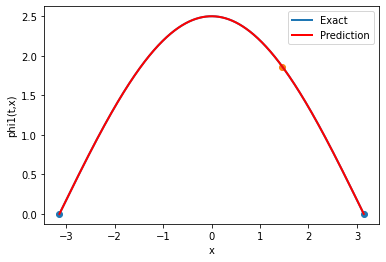

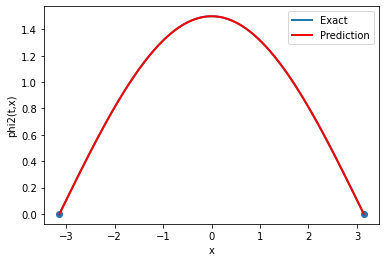

In [ ]:
#@title PINN Neutron Diffusion in 2D *in progress


!pip install pyDOE

%tensorflow_version 1.x

import os

def restore(session, save_file, raise_if_not_found=False, copy_mismatched_shapes=False):
    if not os.path.exists(save_file) and raise_if_not_found:
        raise Exception('File %s not found' % save_file)
    reader = tf.train.NewCheckpointReader(save_file)
    saved_shapes = reader.get_variable_to_shape_map()
    var_names = sorted([(var.name, var.name.split(':')[0]) for var in tf.global_variables()
            if var.name.split(':')[0] in saved_shapes])
    var_name_to_var = {var.name : var for var in tf.global_variables()}
    restore_vars = []
    restored_var_names = set()
    restored_var_new_shape = []
    print('Restoring:')
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        for var_name, saved_var_name in var_names:
            if 'global_step' in var_name:
                restored_var_names.add(saved_var_name)
                continue
            curr_var = var_name_to_var[var_name]
            var_shape = curr_var.get_shape().as_list()
            if var_shape == saved_shapes[saved_var_name]:
                restore_vars.append(curr_var)
                print(str(saved_var_name) + ' -> \t' + str(var_shape) + ' = ' +
                      str(int(np.prod(var_shape) * 4 / 10**6)) + 'MB')
                restored_var_names.add(saved_var_name)
            else:
                print('Shape mismatch for var', saved_var_name, 'expected', var_shape,
                      'got', saved_shapes[saved_var_name])
                restored_var_new_shape.append((saved_var_name, curr_var, reader.get_tensor(saved_var_name)))
                print('bad things')
    ignored_var_names = sorted(list(set(saved_shapes.keys()) - restored_var_names))
    print('\n')
    if len(ignored_var_names) == 0:
        print('Restored all variables')
    else:
        print('Did not restore:' + '\n\t'.join(ignored_var_names))

    if len(restore_vars) > 0:
        saver = tf.train.Saver(restore_vars)
        saver.restore(session, save_file)

    if len(restored_var_new_shape) > 0 and copy_mismatched_shapes:
        print('trying to restore misshapen variables')
        assign_ops = []
        for name, kk, vv in restored_var_new_shape:
            copy_sizes = np.minimum(kk.get_shape().as_list(), vv.shape)
            slices = [slice(0,cs) for cs in copy_sizes]
            print('copy shape', name, kk.get_shape().as_list(), '->', copy_sizes.tolist())
            new_arr = session.run(kk)
            new_arr[slices] = vv[slices]
            assign_ops.append(tf.assign(kk, new_arr))
        session.run(assign_ops)
        print('Copying unmatched weights done')
    print('Restored %s' % save_file)
    try:
        start_iter = int(save_file.split('-')[-1])
    except ValueError:
        print('Could not parse start iter, assuming 0')
        start_iter = 0
    return start_iter


def restore_from_dir(sess, folder_path, raise_if_not_found=False, copy_mismatched_shapes=False):
    start_iter = 0
    ckpt = tf.train.get_checkpoint_state(folder_path)
    if ckpt and ckpt.model_checkpoint_path:
        print('Restoring')
        start_iter = restore(sess, ckpt.model_checkpoint_path, raise_if_not_found, copy_mismatched_shapes)
    else:
        if raise_if_not_found:
            raise Exception('No checkpoint to restore in %s' % folder_path)
        else:
            print('No checkpoint to restore in %s' % folder_path)
    return start_iter

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(1234)
tf.set_random_seed(1234)

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, y0, u0, v0, x1, y1, u1, v1, X_f, layers, lb, ub):
        
        X0 = x0 # (x0, 0)
        X1 = x1


        Y0 = y0 # (x0, 0)
        Y1 = y1

        self.lb = lb
        self.ub = ub

        
               
        self.x0 = X0
        self.x1 = X1

        self.y0 = Y0
        self.y1 = Y1

        
        self.x_f = X_f
        self.y_f = Y_f
        
        self.u0 = u0
        self.v0 = v0

        self.u1 = u1
        self.v1 = v1
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        

        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.x1_tf = tf.placeholder(tf.float32, shape=[None, self.x1.shape[1]])

        self.y0_tf = tf.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.y1_tf = tf.placeholder(tf.float32, shape=[None, self.y1.shape[1]])

        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.u1_tf = tf.placeholder(tf.float32, shape=[None, self.u1.shape[1]])
        self.v1_tf = tf.placeholder(tf.float32, shape=[None, self.v1.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.y_f_tf = tf.placeholder(tf.float32, shape=[None, self.y_f.shape[1]])


        #tf save
        self.saver = tf.train.Saver()

        # tf Graphs
        self.u0_pred, self.v0_pred, _ , _, _ , _  = self.net_uv(self.x0_tf,self.y0_tf)
        self.u1_pred, self.v1_pred, _ , _ , _ , _ = self.net_uv(self.x1_tf,self.y1_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf,self.y_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u1_tf - self.u1_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0* np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                

        

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

        
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, y):
        X = tf.concat([x,y],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
          
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        u_y = tf.gradients(u, y)[0]
        v_y = tf.gradients(v, y)[0]

        return u, v, u_x, v_x, u_y, v_y

    def net_f_uv(self, x):
        u, v, u_x, v_x, u_y, v_y = self.net_uv(x)
        
        u_xx = tf.gradients(u_x, x)[0]
        
        v_xx = tf.gradients(v_x, x)[0]

        u_yy = tf.gradients(u_y, y)[0]
        
        v_yy = tf.gradients(v_y, y)[0]
        
        
        f_v = ( d1*u_xx + (-1)*r1*u + (1/k)*(nu*f1*u + nu*f2*v) ) + ( d1*u_yy + (-1)*r1*u + (1/k)*(nu*f1*u + nu*f2*v) )
        f_u = ( d2*v_xx + (-1)*r2*v + s1*u ) + ( d2*v_yy + (-1)*r2*v + s1*u )   
        
        return f_u, f_v
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0,
                   self.x1_tf: self.x1,
                   self.y0_tf: self.y0,
                   self.y1_tf: self.y1,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.u1_tf: self.u1, self.v1_tf: self.v1,
                   self.x_f_tf: self.x_f,
                   self.y_f_tf: self.y_f}
        
        start_time = time.time()

        restore_from_dir(self.sess, "./ckpt1/") 

        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
            if it % 100 == 0:
                self.saver.save(self.sess, './ckpt1/model',global_step=it,meta_graph_suffix='meta', write_meta_graph=True, write_state=True,
                                strip_default_attrs=False, save_debug_info=False)

        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1],self.y0_tf: Y_star[:,0:1]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1],self.y_f_tf: Y_star[:,0:1]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, f_u_star, f_v_star
    
if __name__ == "__main__":        
    
    # Doman bounds
    a = 2*np.pi #@param {}
    lb = (-1)*a/2
    ub = a/2

    N0 = 2
    N1 = 1
    N_f = 40000
    layers = [2, 100, 100, 100, 2]
        
    #CONSTANTS 
    d1 = 1 #@param {}
    d2 = 0.8 #@param {}
    r1 = 0.15 #@param {}
    r2 = 0.3 #@param {}
    s1 = 0.3 #@param {}
    f1 = 0.55 #@param {}
    f2 = 0.7 #@param {}
    F = 2.5 #@param {}
    nu = 1
    k = ( (r2 + d2*((np.pi/a)**2)) * nu*f1 + s1*nu*f2) / ( (d1*((np.pi/a)**2) + r1) * (d2 * ((np.pi/a)**2) + r2))

    x = np.linspace(lb,ub,2001)
    x = np.reshape(x,(2001,1))

    y = np.linspace(lb,ub,2001)
    y = np.reshape(y,(2001,1))

    Exact_u = F * np.cos((np.pi*x)/a) + F * np.cos((np.pi*y)/a)
    Exact_v = (F * np.cos((np.pi*x)/a))*s1/(r2+d2*((np.pi/a)**2)) + (F * np.cos((np.pi*y)/a))*s1/(r2+d2*((np.pi/a)**2))

    X, Y = np.meshgrid(x,y)
    

    X_star = x.flatten()[:,None]
    Y_star = y.flatten()[:,None]
    u_star = Exact_u.T.flatten()[:,None]
    v_star = Exact_v.T.flatten()[:,None]
    ###########################
    
    idx_x = np.array((0,2000))  # B.C. 
    x0 = x[idx_x,:]
    u0x = Exact_u[idx_x,:]
    v0x = Exact_v[idx_x,:]

    idx_rand = np.random.choice(x.shape[0], N1, replace=False) # N1 random points (experimental data) 
    x1 = x[idx_rand,:]
    u1x = Exact_u[idx_rand,:]
    v1x = Exact_v[idx_rand,:]
    
    idx_y = np.array((0,2000))  # B.C. for Y
    y0 = y[idx_y,:]
    u0y = Exact_u[idx_y,:]
    v0y = Exact_v[idx_y,:]

    idy_rand = np.random.choice(x.shape[0], N1, replace=False) # N1 random points (experimental data) 
    y1 = y[idy_rand,:]
    u1y = Exact_u[idy_rand,:]
v1y = Exact_v[idy_rand,:]
    
    
    X_f = lb + (ub-lb)*lhs(1, N_f)
    Y_f = lb + (ub-lb)*lhs(1, N_f)

    print(X_f.shape)        
    model = PhysicsInformedNN(x0, u0x, v0x, x1, u1x, v1x, y0, u0y, v0y, y1, u1y, v1y, X_f, Y_f, layers, lb, ub)
    
    #@markdown Choose number of epoch
    epoch = 1000 #@param {type:"slider", min:1000, max:10000, step:10}
             
    start_time = time.time()                
    model.train(epoch)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
        
    u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
            
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
    print('Error u: %e' % (error_u))
    print('Error v: %e' % (error_v))

    
 
    ######################################################################
    ############################# Plotting ###############################
    ######################################################################    
    
      

    plt.plot(x,Exact_u[:], linewidth = 2,label = 'Exact')  
    plt.scatter(x0,u0) 
    plt.scatter(x1,u1)     
    plt.plot(x,u_pred[:], 'r', linewidth = 2, label = 'Prediction')
    plt.xlabel('x')
    plt.ylabel('phi1(t,x)')  
    plt.legend(loc='best')
    plt.show()
    
    plt.plot(x,Exact_v[:], linewidth = 2,label = 'Exact')       
    plt.plot(x,v_pred[:], 'r', linewidth = 2, label = 'Prediction')
    plt.scatter(x0,v0) 
    plt.xlabel('x')
    plt.ylabel('phi2(t,x)')
    plt.legend(loc='best')
    plt.show()    
    
   

In [ ]:
plt.plot(x,Exact_u[:], linewidth = 2,label = 'Exact')  
plt.scatter(x0,u0) 
plt.scatter(x1,u1)     
plt.plot(x,u_pred[:], 'r', linewidth = 2, label = 'Prediction')
plt.xlabel('x')
plt.ylabel('phi1(t,x)')  
plt.legend(loc='best')
plt.show()

plt.plot(x,Exact_v[:], linewidth = 2,label = 'Exact')       
plt.plot(x,v_pred[:], 'r', linewidth = 2, label = 'Prediction')
plt.scatter(x0,v0) 
plt.xlabel('x')
plt.ylabel('phi2(t,x)')
plt.legend(loc='best')
plt.show() 